In [1]:
import pickle
import pandas as pd 
import numpy as np
import torch
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from openbabel import pybel
import re

In [2]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
import sys
sys.path.append('..')

In [4]:
from utils_eval import build_pdb_dict, pp_match, extract_pp, extract_all_pp, group_by
from pp_matching_specific_site import compute_center
from data_processing.ligand import Ligand

In [25]:
# ligand_name = '1ywn_A_rec_1ywn_lif_lig_tt_docked_0'  # 0 0
# ligand_name = '4b81_B_rec_4ara_c56_lig_tt_min_0'  # 0.41 0.51
# ligand_name = '1lhu_A_rec_1lhn_aon_lig_tt_min_0'  # 0.07 0.11
# ligand_name = '4b84_A_rec_4b84_z5k_lig_tt_min_0'  # 0.60 0.61
# ligand_name = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0'  
# ligand_name = '5hbh_A_rec_5idn_6a7_lig_tt_min_0'
# ligand_name = '5aen_A_rec_5ni2_dj3_lig_tt_min_0'
# ligand_name = '3d3e_B_rec_4ijw_1eq_lig_tt_min_0'
# ligand_name = '4yyz_B_rec_3ey4_352_lig_tt_docked_12'
# ligand_name = '4h7c_A_rec_3r58_nps_lig_tt_min_0'  # 0.64 0.70
# ligand_name = '3ey4_C_rec_4k1l_sff_lig_tt_min_0'  # 0.59 0.59 

# ligand_name = '3hfg_A_rec_3hfg_17r_lig_tt_min_0'
# ligand_name = '3ey4_C_rec_5pgu_8k4_lig_tt_min_0'  # 0.11 0.10
# ligand_name = '5ni2_A_rec_5aen_dp8_lig_tt_min_0'
# ligand_name = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0'
# ligand_name = '4yyz_B_rec_2ilt_nn1_lig_tt_min_0'  # 0.16 0.20 
# ligand_name = '4bnn_A_rec_4bnm_tcu_lig_tt_min_0'
# ligand_name = '4yvx_A_rec_1s2a_imn_lig_tt_min_0'
# ligand_name = '3czr_B_rec_4bb5_hd2_lig_tt_min_0'
# ligand_name = '3czr_A_rec_2ilt_nn1_lig_tt_min_0'
# ligand_name = '4b84_A_rec_4btl_5gz_lig_tt_min_0'
# ligand_name = '3fue_A_rec_3ftv_11x_lig_tt_min_0'  # 0.04 0.05
# ligand_name = '4bnk_B_rec_4d44_ja3_lig_tt_min_0'  # 0.26 0.27
# ligand_name = '3qqp_B_rec_4k1l_sff_lig_tt_min_0'
# ligand_name = '4wdu_A_rec_3r94_flr_lig_tt_min_0'  # 0.37 0.27
# ligand_name = '4alj_A_rec_4bnf_pv4_lig_tt_docked_0'  # 0.24 0.24
# ligand_name = '1ejj_A_rec_1o99_2pg_lig_tt_docked_0'
# ligand_name = '4h96_B_rec_4h95_06u_lig_tt_min_0'  # 0.40 0.42
# ligand_name = '2oa6_D_rec_4kvi_1sv_lig_tt_min_0'  # 0.36 0.41
# ligand_name = '4hx5_B_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '5pgy_D_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '5pgv_A_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '4kux_B_rec_4kvw_jf4_lig_tt_min_0'  # 0.61 0.63
# ligand_name = '4bnk_B_rec_4bnl_w1g_lig_tt_min_0'
# ligand_name = '4b82_B_rec_4ara_c56_lig_tt_min_0'  # 0.42 0.53
# ligand_name = '4pm0_A_rec_4y2b_epk_lig_tt_min_0'
# ligand_name = '4ms6_A_rec_3fuh_5h1_lig_tt_min_0'  # 0.02 0.02
# ligand_name = '5ivg_B_rec_4kvy_jf1_lig_tt_docked_9'  # 0.61 0.69
# ligand_name = '3r8h_A_rec_3r8h_zom_lig_tt_min_0'
# ligand_name = '1aoe_A_rec_3qlr_qlr_lig_tt_docked_4'  # 0.19 0.28
# ligand_name = '2ilt_A_rec_3ey4_352_lig_tt_min_0'  # 0.70 0.71
# ligand_name = '2g1q_A_rec_1x88_nat_lig_tt_min_0'  # 0.59 0.59
# ligand_name = '5imp_B_rec_4kwd_jf2_lig_tt_min_0'  # 0.54 0.55
# ligand_name = '4d45_A_rec_4ali_tcl_lig_tt_min_0'  # 0.57 0.52
# ligand_name = '5ivg_B_rec_4kvw_jf4_lig_tt_min_0'
# ligand_name = '2rbe_C_rec_3byz_h11_lig_tt_min_0'
# ligand_name = '2whr_A_rec_3zlv_hi6_lig_tt_min_0'
# ligand_name = '4hmn_A_rec_3ufy_npx_lig_tt_min_0'
# ligand_name = '4h7c_A_rec_3r6i_jms_lig_tt_min_0'
# ligand_name = '1pha_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1phd_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1phg_A_rec_1phe_piy_lig_tt_min_0'
# ligand_name = '1phg_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1p2y_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1p2y_A_rec_1phe_piy_lig_tt_min_0'
# ligand_name = '5lgq_D_rec_4ikp_4ik_lig_tt_docked_1'
# ligand_name = '1c8j_A_rec_1p2y_nct_lig_tt_min_0'
# ligand_name = '1l5l_A_rec_1l4l_xyd_lig_tt_min_0'
# ligand_name = '4l0s_A_rec_5al5_jl9_lig_tt_min_0'  # not done nicely
# ligand_name = '2pg2_A_rec_2wog_zzd_lig_tt_min_0'
ligand_name = '4yur_A_rec_3cok_anp_lig_tt_min_0'

In [26]:
# ligand_name = 'test4'

In [27]:
bridge_type = 'vp'
root_path = os.path.join('structure_based', bridge_type, ligand_name)
# root_path = os.path.join('ligand_based', ligand_name)
aromatic = True
gen_path = os.path.join(root_path, 'aromatic' if aromatic else 'basic')

In [28]:
score_file = os.path.join(root_path, 'aromatic_matches.pkl' if aromatic else 'basic_matches.pkl')
with open(score_file, 'rb') as f:
    matches = pickle.load(f)
matches

{'3cok_0': array([0, 1, 0, 1, 1, 0, 0, 1])}

In [29]:
test_data = torch.load(os.path.join('structure_based', ligand_name, ligand_name + '_aromatic' + '.pt' if aromatic else ligand_name + '.pt'))
center = compute_center(test_data['target_pos'], test_data['Gt_mask'])

with open(os.path.join('structure_based', ligand_name, 'pp_info.pkl'), 'rb') as f:
    pp_info = pickle.load(f)

pp_info['pp_positions'] = pp_info['pp_positions'] - center
pp_info['pp_positions']

tensor([[ 0.9410,  0.1072,  4.4590],
        [-3.3132, -2.6049,  0.1159],
        [-2.9137, -0.9988,  2.2015],
        [ 2.7402,  2.1479,  4.9037],
        [ 1.4788,  1.3488, -2.6813],
        [ 1.7789,  1.2487,  2.0410],
        [ 1.9788, -0.7686, -4.1893],
        [-1.5030,  1.5090, -6.3720]])

In [30]:
pp_info['pp_types']

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [31]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [32]:
def test_ref_ligand(gen_lig, ori_lig, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, gen_lig+'.sdf')
    m = Chem.MolFromMolFile(gen_lig)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ori_lig+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [33]:
idx = '0'
lig_id = ligand_name[ligand_name.rfind('rec')+4:ligand_name.rfind('rec')+8]
lig_file = os.path.join(gen_path, lig_id + '_' + idx + '.sdf')
lig_file

'structure_based/vp/4yur_A_rec_3cok_anp_lig_tt_min_0/aromatic/3cok_0.sdf'

In [45]:
rec_mol_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916/ligand_based/reconstructed_mols_aromatic_mode'
lig_file2 = os.path.join(rec_mol_path, ligand_name+'.sdf')

In [34]:
matches[lig_id + '_' + idx]

array([0, 1, 0, 1, 1, 0, 0, 1])

In [35]:
rdmol = Chem.MolFromMolFile(lig_file, sanitize=True)
pbmol = next(pybel.readfile("sdf", lig_file))
try:
    # rdmol = Chem.AddHs(rdmol)
    ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False, preprocess=False)
except:
    print('ligand init failed')
pp_atom_indices, pp_positions, pp_types, pp_index = extract_all_pp(ligand) # extract_pp(ligand) 
print(pp_types)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, [5, 6], [5, 6], [5, 6], [5, 6], [5, 6], 6, 6]


In [36]:
ring = pbmol.sssr[0]
ring.IsAromatic()

False

In [37]:
for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[0.0915 0.0512 0.2164]
['Hydrophobic'] 0
[1]
[-0.514  -0.3143 -3.5802]
['Hydrophobic'] 1
[4]
[0.034  0.0714 0.1629]
['Hydrophobic'] 2
[6]
[1.2866 1.1387 0.7008]
['Hydrophobic'] 3
[9]
[-0.026  -0.4581  1.9346]
['Hydrophobic'] 4
[10]
[ 0.2143 -1.0056  1.0323]
['Hydrophobic'] 5
[14]
[0.8883 0.5846 1.877 ]
['Hydrophobic'] 6
[16]
[-1.1998 -1.3691 -3.2455]
['Hydrophobic'] 7
[17]
[-0.1043 -0.1523 -0.2198]
['Hydrophobic'] 8
[19]
[ 0.2037  1.5252 -3.8547]
['Hydrophobic'] 9
[23]
[ 0.8422  2.1021 -7.3756]
['Hydrophobic'] 10
[26]
[-3.0147 -2.6645 -1.02  ]
['HBond_donor', 'HBond_acceptor'] 11
[3]
[-1.2132 -0.4862  0.429 ]
['HBond_donor', 'HBond_acceptor'] 12
[5]
[ 0.7915 -0.1873  4.2981]
['HBond_donor', 'HBond_acceptor'] 13
[15]
[ 1.3543  0.2792 -5.1654]
['HBond_donor', 'HBond_acceptor'] 14
[20]
[-1.4026  1.5082 -7.2375]
['HBond_donor', 'HBond_acceptor'] 15
[25]
[2.4337 1.7533 3.8871]
['HBond_acceptor'] 16
[12]
[ 0.7305  0.9484 -1.8448]
['HBond_acceptor'] 17
[21]


In [48]:
rdmol2 = Chem.MolFromMolFile(lig_file2, sanitize=True)
pbmol2 = next(pybel.readfile("sdf", lig_file2))
try:
    # rdmol = Chem.AddHs(rdmol)
    ligand2 = Ligand(pbmol2, rdmol2, atom_positions=None, conformer_axis=None, filtering=False, preprocess=False)
except:
    print('ligand init failed')

In [49]:
for node in ligand2.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[-2.8905 -0.9693  0.6525]
['Hydrophobic'] 0
[4]
[-1.3123 -0.2754  0.5666]
['Hydrophobic'] 1
[5]
[ 0.6625 -0.3826  1.3515]
['Hydrophobic'] 2
[7]
[-1.6711 -1.5905 -2.5104]
['Hydrophobic'] 3
[17]
[1.02884 0.28482 4.48096]
['Aromatic'] 4
[10, 11, 13, 14, 16]
[-0.3863  2.0215 -5.3293]
['Anion'] 5
[23, 24, 25, 26]
[-0.0339 -1.8479 -0.7183]
['HBond_donor', 'HBond_acceptor'] 6
[1]
[1.1495 1.1902 1.4993]
['HBond_donor', 'HBond_acceptor'] 7
[9]
[1.3966 0.5925 5.0888]
['HBond_donor', 'HBond_acceptor'] 8
[16]
[-3.893  -2.6735 -0.5901]
['HBond_acceptor'] 9
[3]
[ 0.4336 -0.3888  4.4471]
['HBond_acceptor'] 10
[10]
[ 0.7207 -0.1113  5.056 ]
['HBond_acceptor'] 11
[11]
[2.5883 2.316  4.43  ]
['HBond_acceptor'] 12
[12]
[ 0.0828 -0.1836  0.296 ]
['HBond_acceptor'] 13
[18]
[-0.0009 -0.1142  0.5889]
['HBond_acceptor'] 14
[19]
[ 0.1368  0.7517 -1.4752]
['HBond_acceptor'] 15
[20]
[ 0.213   0.3101 -1.2074]
['HBond_acceptor'] 16
[21]
[ 0.6595  0.8058 -2.9097]
['HBond_acceptor'] 17
[22]
[-0.7224  1.8213 -4.0508]

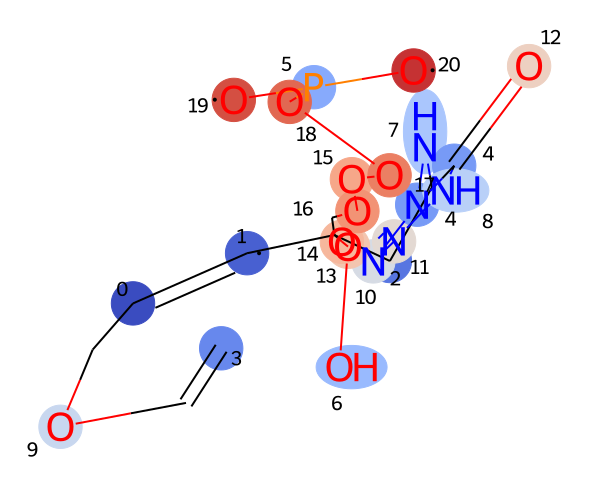

In [50]:
mol_, highlights = group_by(rdmol2, ligand2)
imgsize = (600, 500)
drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
drawer.DrawMolecule(mol_, **highlights)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:','')))

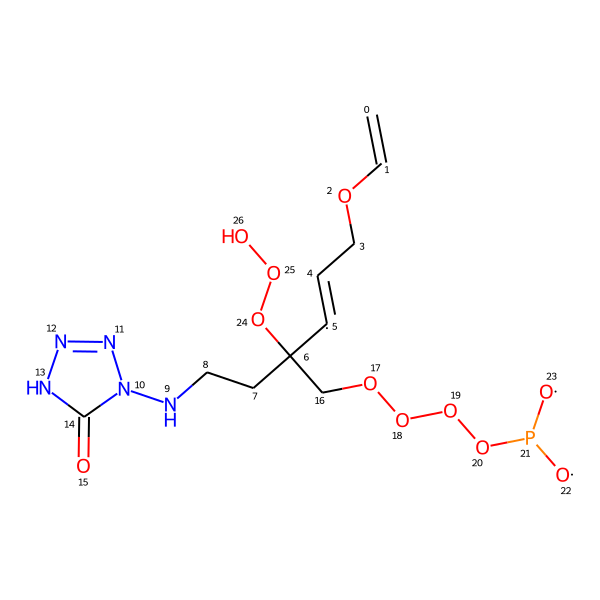

In [52]:
Chem.MolFromSmiles(Chem.MolToSmiles(rdmol2))

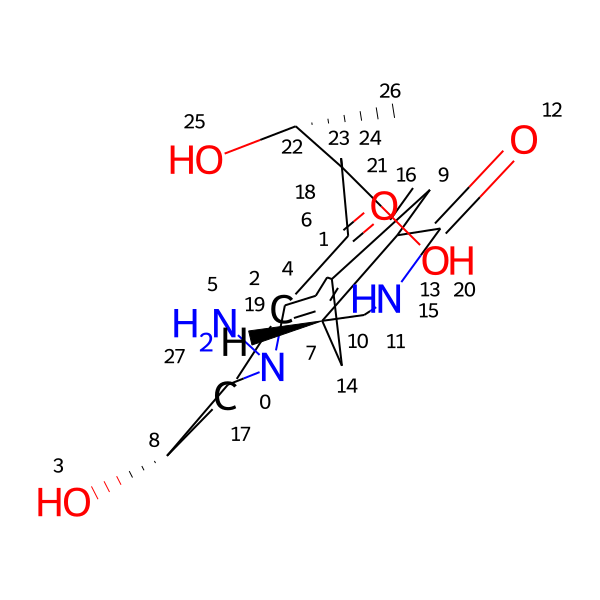

In [53]:
m, ref_m = test_ref_ligand(lig_file, ligand_name)
m

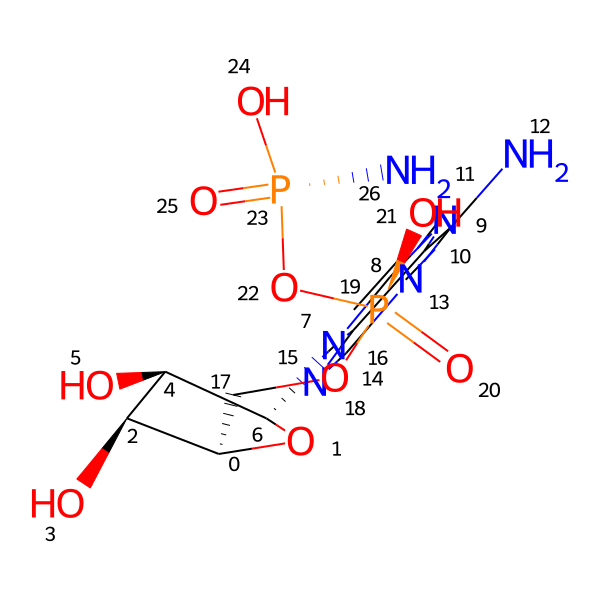

In [54]:
ref_m

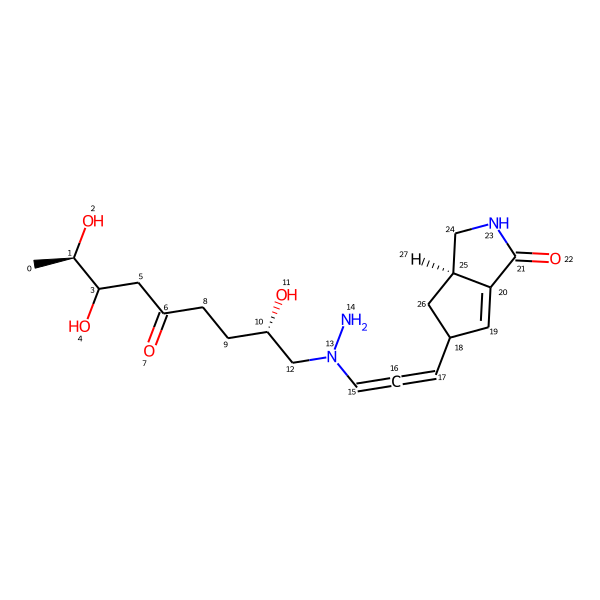

In [41]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

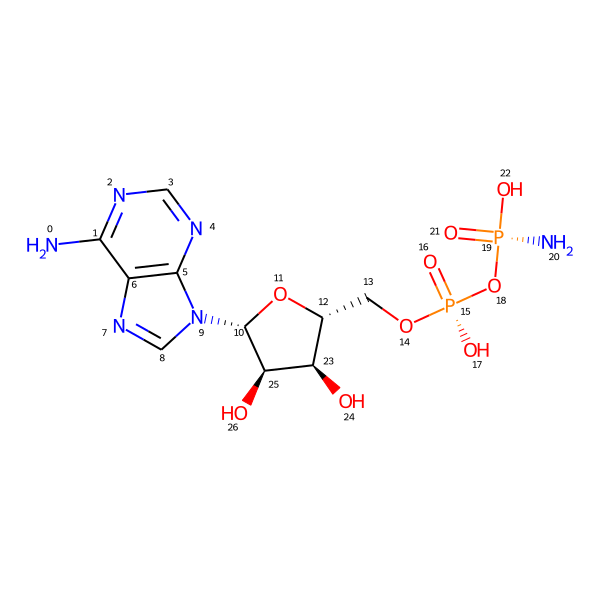

In [42]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [43]:
def compare(gen_lig, ori_lig, gen_path=gen_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ori_lig)
    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    # protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ori_lig[ori_lig.rfind('rec')+4:ori_lig.rfind('lig')+3]
    # autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')
    autobox_ligand_file = os.path.join('structure_based', ori_lig, ori_lig+'.sdf')

    ligand_file = gen_lig # os.path.join(gen_path, gen_lig+'.sdf')

    # out_folder = 'output_aromatic' if aromatic else 'output'
    # out_file = os.path.join(root_path, out_folder, gen_lig)
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    v.rotate(90)
    # v.animate({'interval':1000})
    
    return v

In [44]:
compare(lig_file, ligand_name)

4yur_A_rec


FileNotFoundError: [Errno 2] No such file or directory: 'structure_based/4yur_A_rec_3cok_anp_lig_tt_min_0/4yur_A_rec_3cok_anp_lig_tt_min_0.sdf'

In [184]:
def compare_test(gen_lig, ori_lig, gen_path=gen_path):
    gen_lig_file = os.path.join(gen_path, gen_lig+'.sdf')
    ori_lig_file = os.path.join(gen_path, '..', ori_lig+'.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(ori_lig_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(gen_lig_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    # v.rotate(90)

    return v

In [111]:
# gen_lig = 't4_359'
# compare_test(gen_lig, ligand_name)